# PyTorch Neural Network Classification

| **Topic** | **Contents** |
| ----- | ----- |
| **0. Architecture of a classification neural network** | Neural networks can come in almost any shape or size, but they typically follow a similar floor plan. |
| **1. Getting binary classification data ready** | Data can be almost anything but to get started we're going to create a simple binary classification dataset. |
| **2. Building a PyTorch classification model** | Here we'll create a model to learn patterns in the data, we'll also choose a **loss function**, **optimizer** and build a **training loop** specific to classification. | 
| **3. Fitting the model to data (training)** | We've got data and a model, now let's let the model (try to) find patterns in the (**training**) data. |
| **4. Making predictions and evaluating a model (inference)** | Our model's found patterns in the data, let's compare its findings to the actual (**testing**) data. |
| **5. Improving a model (from a model perspective)** | We've trained and evaluated a model but it's not working, let's try a few things to improve it. |
| **6. Non-linearity** | So far our model has only had the ability to model straight lines, what about non-linear (non-straight) lines? |
| **7. Replicating non-linear functions** | We used **non-linear functions** to help model non-linear data, but what do these look like? |
| **8. Putting it all together with multi-class classification** | Let's put everything we've done so far for binary classification together with a multi-class classification problem. |

## 0. Architecture of a classification neural network

Before we get into writing code, let's look at the general architecture of a classification neural network.

| **Hyperparameter** | **Binary Classification** | **Multiclass classification** |
| --- | --- | --- |
| **Input layer shape** (`in_features`) | Same as number of features (e.g. 5 for age, sex, height, weight, smoking status in heart disease prediction) | Same as binary classification |
| **Hidden layer(s)** | Problem specific, minimum = 1, maximum = unlimited | Same as binary classification |
| **Neurons per hidden layer** | Problem specific, generally 10 to 512 | Same as binary classification |
| **Output layer shape** (`out_features`) | 1 (one class or the other) | 1 per class (e.g. 3 for food, person or dog photo) |
| **Hidden layer activation** | Usually [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU) (rectified linear unit) but [can be many others](https://en.wikipedia.org/wiki/Activation_function#Table_of_activation_functions) | Same as binary classification |
| **Output activation** | [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) ([`torch.sigmoid`](https://pytorch.org/docs/stable/generated/torch.sigmoid.html) in PyTorch)| [Softmax](https://en.wikipedia.org/wiki/Softmax_function) ([`torch.softmax`](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) in PyTorch) |
| **Loss function** | [Binary crossentropy](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression) ([`torch.nn.BCELoss`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) in PyTorch) | Cross entropy ([`torch.nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) in PyTorch) |
| **Optimizer** | [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) (stochastic gradient descent), [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) (see [`torch.optim`](https://pytorch.org/docs/stable/optim.html) for more options) | Same as binary classification |

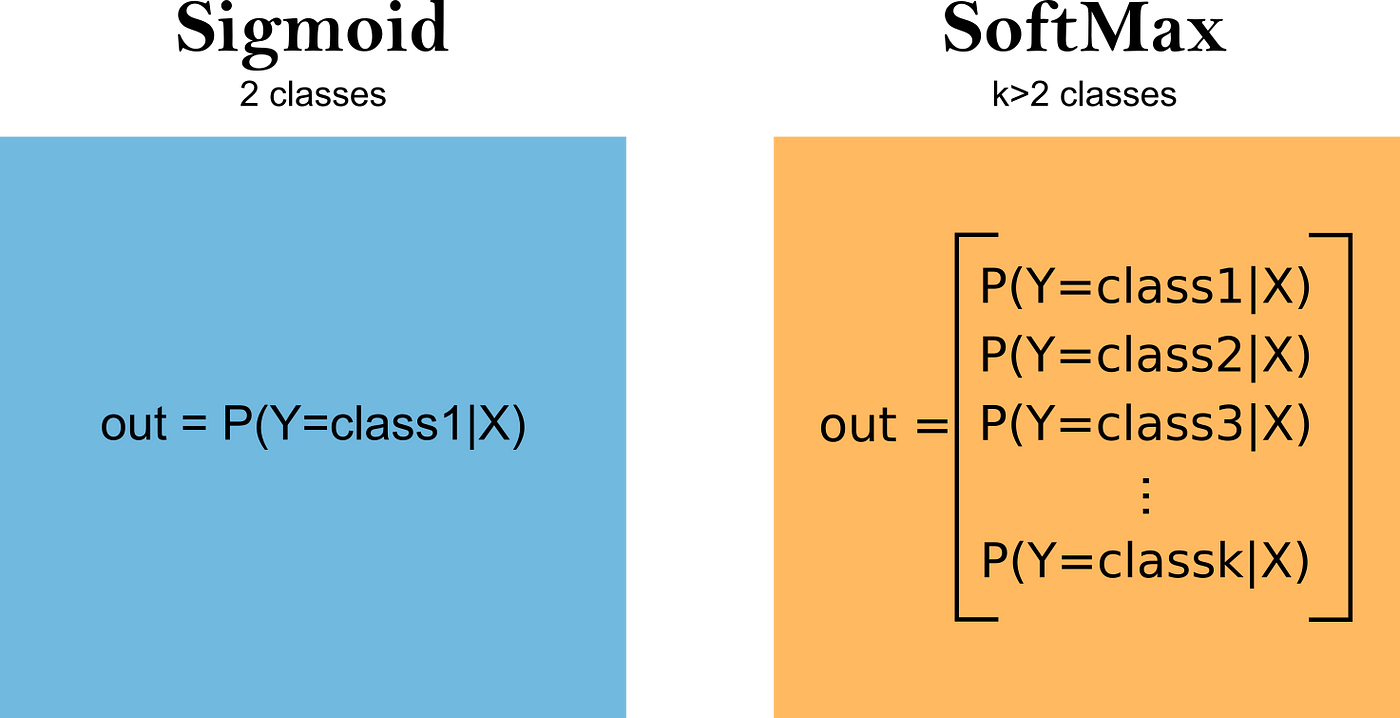

## 1. Binary data creation
Using `make_circle()` from sklearn to make 2 circles with different colored dots.

In [60]:
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn

In [51]:
#1000 samples
n_samples = 1000

#creating circles
X, y = make_circles(n_samples, 
                    noise=0.03,
                    random_state=42)

In [52]:
X[:5],y[:5]

#2 Values in our X, (x, y) coords, while y is labels (color)

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0], dtype=int64))

#

In [53]:
circles = pd.DataFrame({'X': X[:,0],
                        'Y': X[:,1],
                        'label': y})

circles.head()

#X1 = x, X2 = y, label = color

,X,Y,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


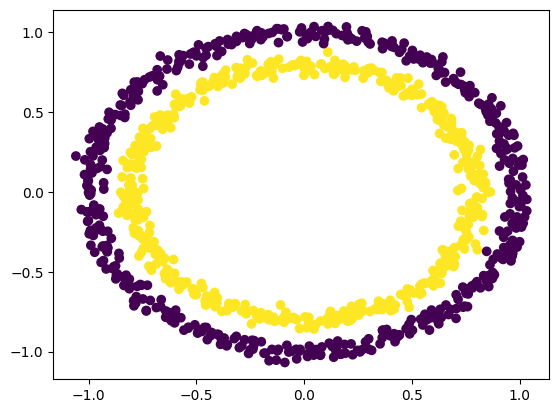

In [54]:
plt.scatter('X', 'Y', c='label', data=circles)

One of the most common errors is shape errors, where the shapes missmatch, so make yourself familiar with shapes, by checking it often.

In [55]:
X.shape, y.shape

((1000, 2), (1000,))

Match in first dimention (1000), but not second (2, 1).

We have 2 inputs for X (vector), for 1 output for y (scalar). 

### Data to tensors

In [56]:
X = torch.from_numpy(X).type(torch.float) #double make sure its float
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [58]:
#split into train test, we can do it like before but wasier with sklear

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Model building

1. Setup device in agnostic mode, GPU if available CPU if not
2. Making model with `nn.Module`
3. Defining the loss_fn and optimizer
4. Training loop

In [61]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
f'Using: {device}'

'Using: cpu'

For model, given `X` features (2) preddict `y` label (1).

1. Subcalsses `nn.Module`
2. Creates 2 `nn.Linear` layers in the contrsuctor capable of taking in input and output
3. Define `forward()` method for forward pass
4. instatiate the model to `device`

In [67]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()

        #Create 2 nn.Lineat layers, instead of  doing each parameter individually
        self.layer_1 = nn.Linear(in_features=2, out_features=5) #hidden layer has 5 units, (arbitary number, 10, 20), allows for more complex
        #Dont set too, high, overfitting, diminishing return, complexity, resources
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

    def forward(self):
        #computation gord trough layer 1 first then layer 2
        return self.layer_2(self.layer_1)        
    
model = CircleModelV0().to(device)
model.state_dict

<bound method Module.state_dict of CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)>

`self.layer_1` takes 2 input features `in_features=2` and produces 5 output features `out_features=5`.

This is having **5 hidden neurons**. Why?

Allows model to learn from 5 numbers rather than 2, potentially leading to better output. This is a **hyperparameter**

![A visual example of what a classification neural network with linear activation looks like on the tensorflow playground](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/02-tensorflow-playground-linear-activation.png)
*A visual example of what a similar classification neural network to the one we've just built looks like. Try creating one of your own on the [TensorFlow Playground website](https://playground.tensorflow.org/).*

You can also do the same as above using [`nn.Sequential`](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html).

`nn.Sequential` performs a forward pass computation of the input data through the layers in the order they appear.

In [68]:
#replicating using Sequential

mode_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

Looks easy, whats the catch?

As name suggests it always runs sequnetially.